In [1]:
!pip install torch torchdata
!pip install transformers datasets
!pip install -q -U bitsandbytes
!pip install -U accelerate
!pip install evaluate rouge_score
!pip install -qqq trl
!pip install loralib peft

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer,DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig
from datasets import load_dataset, DatasetDict, load_metric
import accelerate

import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt


In [3]:
seperator_print_short = '-'.join('' for x in range(100))
seperator_print_long = '-'.join('' for x in range(140))

def print_input_outputs(i, index, input, label, model_output):
    print(seperator_print_long)

    print(f"Sample {i+1}: Index = {index}")
    print(seperator_print_short)

    print(f"INPUT:")
    print(input)
    print(seperator_print_short)

    print("DATASET ORIGINAL LABEL:")
    print(label)
    print(seperator_print_short)

    if model_output != "":
        print("OUTPUT OF THE MODEL")
        print(model_output)
        print(seperator_print_short)

    print(seperator_print_long)



In [4]:
dataset_origin = load_dataset("abatilo/myanimelist-embeddings")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/20051 [00:00<?, ? examples/s]

In [5]:
dset_train_test = (load_dataset("abatilo/myanimelist-embeddings",split='train')
          .train_test_split(train_size=0.7)
          )

dset_train_test

DatasetDict({
    train: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 14035
    })
    test: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 6016
    })
})

In [6]:
dset_test_val = dset_train_test["test"].train_test_split(train_size=0.75)
dset_test_val

DatasetDict({
    train: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 4512
    })
    test: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 1504
    })
})

In [7]:
dataset = DatasetDict({
                      'train': dset_train_test['train'],
                      'validation': dset_test_val['train'],
                      'test': dset_test_val['test']}
                      )

dataset

DatasetDict({
    train: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 14035
    })
    validation: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 4512
    })
    test: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 1504
    })
})

In [8]:
dataset['train'] = dataset['train'].shuffle().select([i for i in range(6000)])
dataset['validation'] = dataset['validation'].shuffle().select([i for i in range(1000)])
dataset['test'] = dataset['test'].shuffle().select([i for i in range(250)])
dataset

DatasetDict({
    train: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['embedding', 'alternative_titles', 'synopsis', 'id', 'title'],
        num_rows: 250
    })
})

In [9]:

INPUT_COL_NAME = "synopsis"
OUTPUT_COL_NAME = "title"

In [10]:
 from transformers import BitsAndBytesConfig
 BNB_NF4_CONFIG = BitsAndBytesConfig(
     load_in_4bit=True,
     bnb_4bit_use_double_quant=True,
     bnb_4bit_quant_type="nf4",
     bnb_4bit_compute_dtype=torch.bfloat16
 )

In [11]:
model_id='google/flan-t5-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_id,
                                              quantization_config = BNB_NF4_CONFIG,
                                              device_map = "auto"
                                              )

tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          use_fast=True,
                                          )


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [12]:
LORA_R = 8
LORA_ALPHA = 64
LORA_DROPOUT = 0.01

lora_config=LoraConfig(
    r = LORA_R,
    lora_alpha = LORA_ALPHA,
    target_modules = ["q","v"],
    lora_dropout = LORA_DROPOUT,
    bias = "lora_only",
    task_type = TaskType.SEQ_2_SEQ_LM
)

peft_model=get_peft_model(model,lora_config)

In [13]:
def tokenize_function(example):
    START_prompt = 'Generate a relevant title related to the given synopsis:'
    END_prompt = '\n\nGenerated Title: '

    prompt = [START_prompt + synopsis + END_prompt for synopsis in example[INPUT_COL_NAME]]
    example['input_ids'] = tokenizer(prompt,
                                    padding=True,
                                    truncation=True,
                                    return_tensors="pt").input_ids

    example['labels'] = tokenizer(example["title"],
                                  padding=True,
                                  truncation=True,
                                  return_tensors="pt").input_ids

    return example


tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [14]:
tokenized_datasets = tokenized_datasets.remove_columns(['embedding', 'alternative_titles', 'synopsis', 'id', 'title'])
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 250
    })
})


In [15]:
output_model_name = "flantT5"
output_config_option = "peftqlora"
output_task = "title-generation"

OUTPUT_DIR = f'./{output_model_name}-{output_config_option}-{output_task}'

In [16]:
peft_training_args = TrainingArguments(
    output_dir = OUTPUT_DIR,
    num_train_epochs = 4,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 2,
    learning_rate = 2e-4,
    optim = "paged_adamw_32bit" ,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "epoch",
    logging_steps = 4,
    metric_for_best_model = 'eval_loss'
)



model.config.use_cache = False

peft_trainer = Trainer(
    model = peft_model,
    args = peft_training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation'],
    data_collator=DataCollatorForSeq2Seq(tokenizer),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
peft_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.882300,0.689941
2,0.921400,0.676758
3,0.825800,0.676270
4,0.889700,0.665039


TrainOutput(global_step=3000, training_loss=0.9513226928710937, metrics={'train_runtime': 3516.7138, 'train_samples_per_second': 6.825, 'train_steps_per_second': 0.853, 'total_flos': 1.651865558188032e+16, 'train_loss': 0.9513226928710937, 'epoch': 4.0})

In [19]:
PATH_peft_model="./flantT5-lora-title-generator"

peft_trainer.model.save_pretrained(PATH_peft_model)
tokenizer.save_pretrained(PATH_peft_model)

('./flantT5-lora-title-generator/tokenizer_config.json',
 './flantT5-lora-title-generator/special_tokens_map.json',
 './flantT5-lora-title-generator/spiece.model',
 './flantT5-lora-title-generator/added_tokens.json',
 './flantT5-lora-title-generator/tokenizer.json')

In [20]:
peft_model = PeftModel.from_pretrained(model,
                                       PATH_peft_model,
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [21]:
TEST_INDEX = 23

synopsis = dataset['test'][TEST_INDEX][INPUT_COL_NAME]
title = dataset['test'][TEST_INDEX][OUTPUT_COL_NAME]

prompt = f"""
Generate a title related to the given synopsis:
{synopsis}

Generated Title:
"""
inputs = tokenizer(prompt, return_tensors='pt')

output_peft = tokenizer.decode(
    peft_model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig(max_new_tokens=70,
                                             temperatue=1,
                                             do_sample=True),
    )[0],
    skip_special_tokens = True
)


print(prompt)
print(seperator_print_short)

print('Label:')
print(title)
print(seperator_print_short)

print('PEFT Summary:')
print(output_peft)
print(seperator_print_short)




Generate a title related to the given synopsis:
A high school loner is given the part-time job of a lifetime as a modern day ninja tasked to perform international assassinations.

After World War II, Allied Command in Japan developed a new agency to help manage terrorism and violence within the Pacific region. The agency was staffed with ninja and they were initially tasked to handle domestic affairs. Eventually that program grew to its current form, managing 20,000 ninja across a range of domestic and international affairs. One of those ninjas happens to be Kudo. The seventeen-year-old high school loser is now poised to be the next line of defense against a potential surge in foreign assassins invading Tokyo. 

(Source: Denpa, edited)

Generated Title:

---------------------------------------------------------------------------------------------------
Label:
Under Ninja
---------------------------------------------------------------------------------------------------
PEFT Summary:
K

In [22]:
metric = evaluate.load("rouge")

def get_decoded_pred_samples(sample, max_target_length=40):
    outputs = peft_model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
                             do_sample=True,
                             max_new_tokens=max_target_length)
    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(),
                                  skip_special_tokens=True)
    labels = np.where(sample['labels'] != -100,
                      sample['labels'],
                      tokenizer.pad_token_id)

    labels = tokenizer.decode(labels, skip_special_tokens=True)
    return prediction, labels


In [23]:
test_dataset = tokenized_datasets['test'].with_format("torch")
df_list_elements = []

predictions, references = [] , []
for sample in tqdm(test_dataset):
    pred, y = get_decoded_pred_samples(sample)
    predictions.append(pred)
    references.append(y)
    df_list_elements.append([sample, y, pred])


100%|██████████| 250/250 [01:40<00:00,  2.48it/s]


In [24]:
for pred in predictions[:5]:
  print(pred)

Uragiri wa Boku no Namae wo Shitteiru
The Vacation of the Dead
Pirates of the Caribbean
Ikirai
An Enormous Delta


In [25]:
rogue = metric.compute(predictions=predictions,
                       references=references,
                       use_stemmer=True)

print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

Rogue1: 28.686140%
rouge2: 20.222228%
rougeL: 28.762640%
rougeLsum: 28.820033%


In [26]:
df_model_results = pd.DataFrame(df_list_elements,
                                columns=["sample", "label", "prediction"])

df_model_results = df_model_results.drop('sample', axis=1)
df_model_results.to_csv('results.csv')
df_model_results

,label,prediction
0,Uragiri wa Boku no Namae wo Shitteiru,Uragiri wa Boku no Namae wo Shitteiru
1,Glass no Kamen desu ga to Z,The Vacation of the Dead
2,One Piece Movie 04: Dead End no Bouken,Pirates of the Caribbean
3,Kinnikuman: Seigi Choujin vs. Kodai Choujin,Ikirai
4,An Enormous Delta,An Enormous Delta
...,...,...
245,Joou-sama wa M Dorei,Iemi
246,Age of Obscure: Boubaku Jidai,A Big One
247,Shiawase Daifuku,Shiawase Daifuku
248,Jingju Mao Zhi Cheng Feng Polang,Jingju Mao


In [27]:
df_trainer_logs = pd.DataFrame(peft_trainer.state.log_history)

df_trainer_logs

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.6826,3.471586,1.997333e-04,0.005333,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.3032,2.897219,1.994667e-04,0.010667,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.8845,3.741837,1.992000e-04,0.016000,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.6580,4.653044,1.989333e-04,0.021333,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.4404,2.470319,1.986667e-04,0.026667,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.8315,0.913340,5.333333e-07,3.989333,2992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751,0.8642,0.883317,2.666667e-07,3.994667,2996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752,0.8897,0.815658,0.000000e+00,4.000000,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,NaN,NaN,NaN,4.000000,3000,0.665039,57.6731,17.339,2.167,NaN,NaN,NaN,NaN,NaN


In [28]:
df_trainer_logs.to_csv('train_logs.csv')

In [29]:
df_trainer_logs = df_trainer_logs[["epoch","loss","eval_loss","learning_rate","step"]]
df_trainer_logs

,epoch,loss,eval_loss,learning_rate,step
0,0.005333,3.6826,NaN,1.997333e-04,4
1,0.010667,3.3032,NaN,1.994667e-04,8
2,0.016000,2.8845,NaN,1.992000e-04,12
3,0.021333,2.6580,NaN,1.989333e-04,16
4,0.026667,2.4404,NaN,1.986667e-04,20
...,...,...,...,...,...
750,3.989333,0.8315,NaN,5.333333e-07,2992
751,3.994667,0.8642,NaN,2.666667e-07,2996
752,4.000000,0.8897,NaN,0.000000e+00,3000
753,4.000000,NaN,0.665039,NaN,3000


Text(0, 0.5, 'Loss')

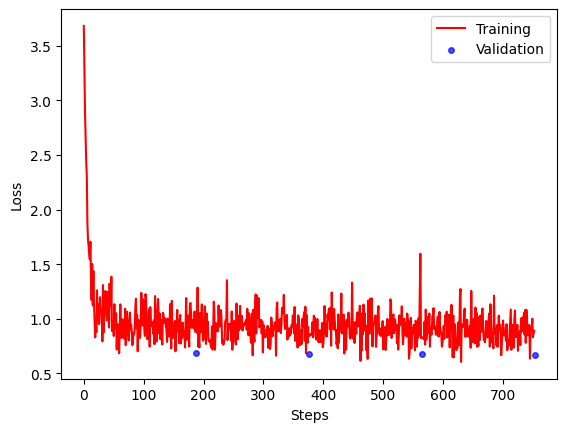

In [30]:
steps = df_trainer_logs.index
train_loss = df_trainer_logs.loss
eval_loss_list = df_trainer_logs.eval_loss

plt.plot(steps, train_loss, label="train_loss", color = "red")
plt.scatter(steps, eval_loss_list,
            c="blue", alpha=0.7, s=16)

plt.legend(["Training", "Validation"], loc ="upper right")
plt.xlabel("Steps")
plt.ylabel("Loss")